In [1]:
#importing necessary libraries

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# load our *serialized face detector model* from disk
print("[INFO] loading face detector model...")
net = cv2.dnn.readNet("deploy.prototxt", "res10_300x300_ssd_iter_140000.caffemodel")
#The structure of the neural network is stored in deploy.prototxt file
#The weights of the layers of the neural network are stored in res10_300x300_ssd_iter_140000.caffemodel file

# load the face mask detector model (*TRAINED PREVIOUSLY*) from disk
print("[INFO] loading face mask detector model...")
model = joblib.load('loaded_model_updated_dataset_3.pkl')


[INFO] loading face detector model...
[INFO] loading face mask detector model...


Using TensorFlow backend.


In [7]:
# load the input image from disk and grab the image spatial dimensions
image = cv2.imread("man_wo.jpg")
(h, w) = image.shape[:2] #height , width , and # of channels.

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))
# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward() #forward in NN #four dimensional array
print(detections.shape) #to see the shape (1,1, 200 #no of detections, 7)
label = ""

[INFO] computing face detections...
(1, 1, 200, 7)


In [8]:
#We have many detections, now we loop over them
for i in range(0, detections.shape[2]):
	confidence = detections[0, 0, i, 2] #confidence for detection of *Mask* from image!

	# greater than the minimum confidence
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int") # ensure the bounding boxes fall within the dimensions of frame

		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# ordering, resize it to 64x64, and preprocess it
		face = image[startY:endY, startX:endX] #extracting face for Region of Interest
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB) #Changing color from BGR to RGB
		face = cv2.resize(face, (64, 64))
		face = img_to_array(face) #converting Image to array for i/p to DL model
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)
  
		# pass the face through the model to determine if the face
		# has a mask or not
		(withoutMask) = model.predict(face)[0][0] 
        # determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if (1-withoutMask) > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label_with_p = "{}: {:.2f}%".format(label, max(1-withoutMask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(image, label_with_p, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)


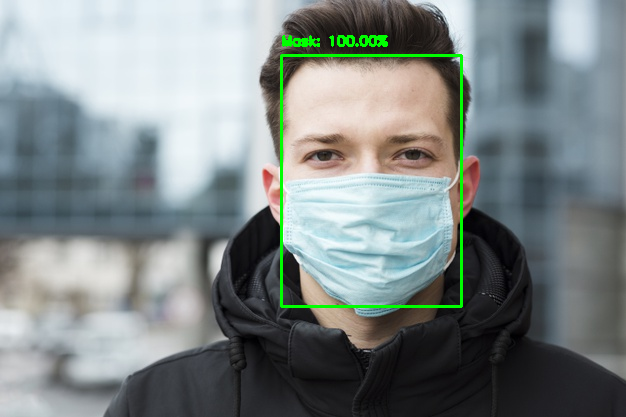

In [6]:
#outputting the image when i/p was man with mask
cv2.imshow(image)

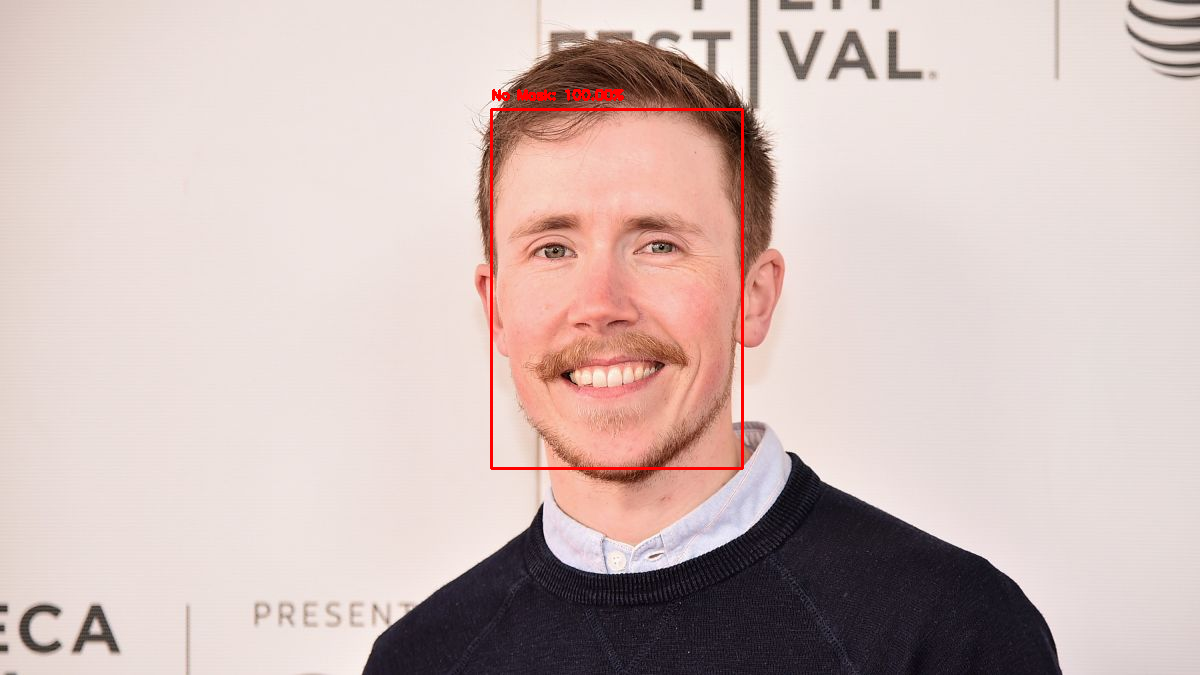

In [9]:
#outputting the image when i/p was man without mask
cv2.imshow(image)